## MM-DES: Multi-Modal Dynamic Ensemble Selecltion Framework

### Data Loading 

In [9]:
import torch
import numpy as np 
import pandas as pd 
from torch.utils.data import Dataset

import warnings
warnings.filterwarnings('ignore')


class MultimodalDataset(Dataset):
    def __init__(self, cxr_path, ecg_path, labs_array, labels):
        self.cxr = np.load(cxr_path, mmap_mode='r')
        self.ecg = np.load(ecg_path, mmap_mode='r')
        self.labs = labs_array  
        self.labels = labels
    
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "cxr": torch.tensor(self.cxr[idx]).float(),
            "ecg": torch.tensor(self.ecg[idx]).float(),
            "labs": torch.tensor(self.labs[idx]).float(),
            "label": torch.tensor(self.labels[idx]).long()
        }

        
# Train Data 
train_directory = "mimic/data_npy/train/"
val_directory =  "mimic/data_npy/val/"
test_directory =  "mimic/data_npy/test/"

labs_train = np.load(f"{train_directory}labs_percentiles_train.npy") 
labs_val = np.load(f"{val_directory}labs_percentiles_val.npy") 
labs_test = np.load(f"{test_directory}labs_percentiles_test.npy")  

# Tabular 
symile_mimic_data = pd.read_csv("mimic/admissions.csv", usecols = ['hadm_id', 'hospital_expire_flag'])
train_meta = pd.read_csv("mimic/train.csv", usecols = ['hadm_id']) 
val_meta = pd.read_csv("mimic/val.csv", usecols = ['hadm_id'])
test_meta = pd.read_csv("mimic/test.csv", usecols = ['hadm_id'])

symile_mimic_data["hadm_id"] = symile_mimic_data["hadm_id"].astype(int)
train_meta["hadm_id"] = train_meta["hadm_id"].astype(int)
val_meta["hadm_id"] = val_meta["hadm_id"].astype(int)
test_meta["hadm_id"] = test_meta["hadm_id"].astype(int)


train_lab_df = pd.DataFrame(labs_train) 
val_lab_df = pd.DataFrame(labs_val) 
test_lab_df = pd.DataFrame(labs_test) 

train_lab_df = train_meta['hadm_id']
val_lab_df = val_meta['hadm_id']
test_lab_df = test_meta['hadm_id']

train_lab_df = pd.merge(train_lab_df, symile_mimic_data, on='hadm_id', how='left')
val_lab_df = pd.merge(val_lab_df, symile_mimic_data, on='hadm_id', how='left')
test_lab_df = pd.merge(test_lab_df, symile_mimic_data, on='hadm_id', how='left')

train_lab_df.fillna(0, inplace=True)
val_lab_df.fillna(0, inplace=True)
test_lab_df.fillna(0, inplace=True)

train_lab_df.columns = train_lab_df.columns.astype(str) 
val_lab_df.columns = val_lab_df.columns.astype(str)
test_lab_df.columns = test_lab_df.columns.astype(str)


train_dataset = MultimodalDataset(
    cxr_path=f"{train_directory}cxr_train.npy",
    ecg_path=f"{train_directory}ecg_train.npy",
    labs_array=labs_train,
    labels=train_lab_df["hospital_expire_flag"].values
)

val_dataset = MultimodalDataset(
    cxr_path=f"{val_directory}cxr_val.npy",
    ecg_path=f"{val_directory}ecg_val.npy",
    labs_array=labs_val,
    labels=val_lab_df["hospital_expire_flag"].values
)

test_dataset = MultimodalDataset(
    cxr_path=f"{test_directory}cxr_test.npy",
    ecg_path=f"{test_directory}ecg_test.npy",
    labs_array=labs_test,
    labels=test_lab_df["hospital_expire_flag"].values
)

In [10]:
data = np.load(f"{train_directory}hadm_id_train.npy")

In [11]:
data

array([25296721, 26188372, 20652011, ..., 21877805, 29958914, 24043239])

In [12]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Batch shapes:
CXR: torch.Size([64, 3, 320, 320])
ECG: torch.Size([64, 1, 5000, 12])
Labs: torch.Size([64, 50])
Labels: torch.Size([64])
Labels example: [0 0 0 0 0]


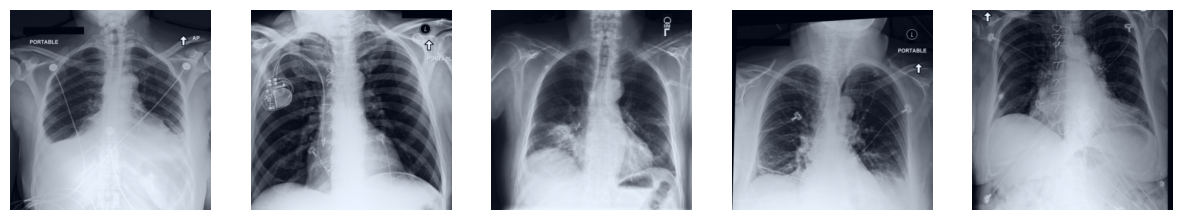

In [13]:
# --------------------------
# Visualize first 5 X-rays + batch info
# --------------------------
batch = next(iter(train_loader))
cxr = batch["cxr"]
ecg = batch["ecg"]
labs = batch["labs"]
labels = batch["label"]

print("Batch shapes:")
print("CXR:", cxr.shape)
print("ECG:", ecg.shape)
print("Labs:", labs.shape)
print("Labels:", labels.shape)
print("Labels example:", labels[:5].numpy())

# Handle normalized images safely for plotting
def prepare_img(img_tensor):
    # Convert CxHxW -> HxWxC
    img = img_tensor.permute(1, 2, 0).numpy()
    # Scale to 0-1 for imshow
    img = (img - img.min()) / (img.max() - img.min() + 1e-6)
    return img

plt.figure(figsize=(15, 3))
for i in range(5):
    img = prepare_img(cxr[i])
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [14]:
cxr.shape

torch.Size([64, 3, 320, 320])

### Embedding 

In [19]:
import torch.nn as nn
import torch.nn.functional as F

class MultimodalEncoder(nn.Module):
    def __init__(self, cxr_dim=512, ecg_dim=256, labs_dim=128, embed_dim=128):
        super().__init__()
        # X-ray encoder (simple CNN or replace with pretrained)
        self.encoder_cxr = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(32, cxr_dim),
            nn.ReLU(),
            nn.Linear(cxr_dim, embed_dim)
        )
        # ECG encoder (1x5000x12 input)
        self.encoder_ecg = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=(3,3), padding=1), nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=(3,3), padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(16, ecg_dim),
            nn.ReLU(),
            nn.Linear(ecg_dim, embed_dim)
        )
        # Labs encoder (tabular)
        self.encoder_labs = nn.Sequential(
            nn.Linear(50, labs_dim), nn.ReLU(),
            nn.Linear(labs_dim, embed_dim)
        )
        # Learnable logit scale
        self.logit_scale = nn.Parameter(torch.ones([]) * np.log(1/0.07))

    def forward(self, cxr, ecg, labs):
        out_cxr = self.encoder_cxr(cxr)
        out_ecg = self.encoder_ecg(ecg)
        out_labs = self.encoder_labs(labs)
        return out_cxr, out_ecg, out_labs, self.logit_scale.exp()

In [101]:
from symile import Symile, MIPSimilarity 
from tqdm import tqdm 
# ----------------------------
# Model / Optimizer / Loss
# ----------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
model = MultimodalEncoder().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
symile_loss_fn = Symile()
mip_similarity = MIPSimilarity()

# ----------------------------
# Training Loop (Example)
# ----------------------------
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(val_loader):
        cxr = batch['cxr'].to(device)
        ecg = batch['ecg'].to(device)
        labs = batch['labs'].to(device)

        optimizer.zero_grad()
        out_cxr, out_ecg, out_labs, logit_scale_exp = model(cxr, ecg, labs)
        
        # Normalize embeddings
        out_cxr = F.normalize(out_cxr, dim=1)
        out_ecg = F.normalize(out_ecg, dim=1)
        out_labs = F.normalize(out_labs, dim=1)
        
        # Symile loss
        loss = symile_loss_fn([out_cxr, out_ecg, out_labs], logit_scale_exp)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(val_loader):.4f}")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.38it/s]


Epoch 1/100, Loss: 4.1308


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.54it/s]


Epoch 2/100, Loss: 4.1186


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.32it/s]


Epoch 3/100, Loss: 4.0836


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.09it/s]


Epoch 4/100, Loss: 4.0657


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.98it/s]


Epoch 5/100, Loss: 4.0548


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.63it/s]


Epoch 6/100, Loss: 4.0353


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.27it/s]


Epoch 7/100, Loss: 4.0108


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.15it/s]


Epoch 8/100, Loss: 4.0004


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.11it/s]


Epoch 9/100, Loss: 3.9983


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.44it/s]


Epoch 10/100, Loss: 3.9906


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.52it/s]


Epoch 11/100, Loss: 3.9717


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.24it/s]


Epoch 12/100, Loss: 3.9475


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.04it/s]


Epoch 13/100, Loss: 3.9372


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.60it/s]


Epoch 14/100, Loss: 3.9033


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.30it/s]


Epoch 15/100, Loss: 3.8425


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.20it/s]


Epoch 16/100, Loss: 3.8239


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.10it/s]


Epoch 17/100, Loss: 3.8145


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.16it/s]


Epoch 18/100, Loss: 3.7654


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.17it/s]


Epoch 19/100, Loss: 3.7376


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.36it/s]


Epoch 20/100, Loss: 3.7154


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.00it/s]


Epoch 21/100, Loss: 3.6987


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.16it/s]


Epoch 22/100, Loss: 3.6174


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.98it/s]


Epoch 23/100, Loss: 3.5601


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.20it/s]


Epoch 24/100, Loss: 3.5079


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.26it/s]


Epoch 25/100, Loss: 3.4307


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.42it/s]


Epoch 26/100, Loss: 3.3909


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.56it/s]


Epoch 27/100, Loss: 3.3678


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.81it/s]


Epoch 28/100, Loss: 3.3320


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.70it/s]


Epoch 29/100, Loss: 3.3312


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.45it/s]


Epoch 30/100, Loss: 3.2463


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.27it/s]


Epoch 31/100, Loss: 3.1884


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.54it/s]


Epoch 32/100, Loss: 3.1381


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.27it/s]


Epoch 33/100, Loss: 3.1019


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.12it/s]


Epoch 34/100, Loss: 3.0480


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.27it/s]


Epoch 35/100, Loss: 3.0242


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.45it/s]


Epoch 36/100, Loss: 3.0224


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.63it/s]


Epoch 37/100, Loss: 2.9864


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.51it/s]


Epoch 38/100, Loss: 2.9016


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.29it/s]


Epoch 39/100, Loss: 2.8660


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.28it/s]


Epoch 40/100, Loss: 2.8619


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.66it/s]


Epoch 41/100, Loss: 2.8168


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 10.18it/s]


Epoch 42/100, Loss: 2.7595


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.64it/s]


Epoch 43/100, Loss: 2.7105


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.55it/s]


Epoch 44/100, Loss: 2.6732


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.38it/s]


Epoch 45/100, Loss: 2.6514


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.64it/s]


Epoch 46/100, Loss: 2.6252


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.75it/s]


Epoch 47/100, Loss: 2.6596


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 10.13it/s]


Epoch 48/100, Loss: 2.6989


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 10.04it/s]


Epoch 49/100, Loss: 2.6808


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 10.05it/s]


Epoch 50/100, Loss: 2.6109


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 10.14it/s]


Epoch 51/100, Loss: 2.6300


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 10.17it/s]


Epoch 52/100, Loss: 2.6275


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 10.05it/s]


Epoch 53/100, Loss: 2.7656


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.91it/s]


Epoch 54/100, Loss: 2.8105


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.83it/s]


Epoch 55/100, Loss: 2.5020


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.97it/s]


Epoch 56/100, Loss: 2.5665


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 10.33it/s]


Epoch 57/100, Loss: 2.5490


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.93it/s]


Epoch 58/100, Loss: 2.4209


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.94it/s]


Epoch 59/100, Loss: 2.3587


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.56it/s]


Epoch 60/100, Loss: 2.2248


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.20it/s]


Epoch 61/100, Loss: 2.2418


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.19it/s]


Epoch 62/100, Loss: 2.2845


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.63it/s]


Epoch 63/100, Loss: 2.3178


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.53it/s]


Epoch 64/100, Loss: 2.2403


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.68it/s]


Epoch 65/100, Loss: 2.2218


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.93it/s]


Epoch 66/100, Loss: 2.2238


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 10.79it/s]


Epoch 67/100, Loss: 2.1003


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 11.52it/s]


Epoch 68/100, Loss: 2.1193


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 11.62it/s]


Epoch 69/100, Loss: 2.0538


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 11.70it/s]


Epoch 70/100, Loss: 1.9463


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 11.25it/s]


Epoch 71/100, Loss: 1.9182


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.82it/s]


Epoch 72/100, Loss: 1.9234


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.77it/s]


Epoch 73/100, Loss: 1.8593


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.78it/s]


Epoch 74/100, Loss: 1.8552


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.58it/s]


Epoch 75/100, Loss: 1.8463


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.55it/s]


Epoch 76/100, Loss: 1.8596


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.65it/s]


Epoch 77/100, Loss: 1.8146


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.68it/s]


Epoch 78/100, Loss: 1.8631


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.74it/s]


Epoch 79/100, Loss: 1.7682


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.53it/s]


Epoch 80/100, Loss: 1.7260


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.67it/s]


Epoch 81/100, Loss: 1.7489


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 10.05it/s]


Epoch 82/100, Loss: 1.6525


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.75it/s]


Epoch 83/100, Loss: 1.7195


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.52it/s]


Epoch 84/100, Loss: 1.7160


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.71it/s]


Epoch 85/100, Loss: 1.7505


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.73it/s]


Epoch 86/100, Loss: 1.6818


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.65it/s]


Epoch 87/100, Loss: 1.7031


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.72it/s]


Epoch 88/100, Loss: 1.6415


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.53it/s]


Epoch 89/100, Loss: 1.6417


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.50it/s]


Epoch 90/100, Loss: 1.7330


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.52it/s]


Epoch 91/100, Loss: 1.7858


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.51it/s]


Epoch 92/100, Loss: 1.8293


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.76it/s]


Epoch 93/100, Loss: 1.9119


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.84it/s]


Epoch 94/100, Loss: 1.8830


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.44it/s]


Epoch 95/100, Loss: 1.8576


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.53it/s]


Epoch 96/100, Loss: 1.8091


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.58it/s]


Epoch 97/100, Loss: 1.7556


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.67it/s]


Epoch 98/100, Loss: 1.7386


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.79it/s]


Epoch 99/100, Loss: 1.6557


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.59it/s]

Epoch 100/100, Loss: 1.5362


In [21]:
import torch
import torch.nn.functional as F
from symile import MIPSimilarity

device = "cuda" if torch.cuda.is_available() else "cpu"

# Assume model is already trained
model.eval()
mip_similarity = MIPSimilarity()

# --- Step 1: Compute DSEL embeddings once ---
dsel_embeddings = {"cxr": [], "ecg": [], "labs": []}

with torch.no_grad():
    for batch in tqdm(val_loader):  # DSEL = val_loader
        cxr = batch['cxr'].to(device)
        ecg = batch['ecg'].to(device)
        labs = batch['labs'].to(device)

        out_cxr, out_ecg, out_labs, logit_scale_exp = model(cxr, ecg, labs)
        out_cxr = F.normalize(out_cxr, dim=1)
        out_ecg = F.normalize(out_ecg, dim=1)
        out_labs = F.normalize(out_labs, dim=1)

        dsel_embeddings['cxr'].append(out_cxr)
        dsel_embeddings['ecg'].append(out_ecg)
        dsel_embeddings['labs'].append(out_labs)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 16.04it/s]


In [22]:
# Concatenate all batches
for k in dsel_embeddings:
    dsel_embeddings[k] = torch.cat(dsel_embeddings[k], dim=0)  # shape: [num_dsel_samples, embed_dim]

In [99]:
# --- Step 2: Compute test sample embeddings ---
test_sample = test_dataset[206] # take one batch; pick first sample
cxr_test = test_sample['cxr'].unsqueeze(0).to(device)  # shape [1, C, H, W]
ecg_test = test_sample['ecg'].unsqueeze(0).to(device)
labs_test = test_sample['labs'].unsqueeze(0).to(device)
print(f"True label: {test_sample['label']}")

with torch.no_grad():
    out_cxr_test, out_ecg_test, out_labs_test, logit_scale_exp = model(cxr_test, ecg_test, labs_test)
    out_cxr_test = F.normalize(out_cxr_test, dim=1)
    out_ecg_test = F.normalize(out_ecg_test, dim=1)
    out_labs_test = F.normalize(out_labs_test, dim=1)


weights = {'cxr': 0.4, 'ecg': 0.4, 'labs': 0.2}  # assign more importance to CXR

# --- Step 1: Compute weighted similarity ---
sim_cxr = mip_similarity(out_cxr_test, [dsel_embeddings['ecg'], dsel_embeddings['labs']])
sim_ecg = mip_similarity(out_ecg_test, [dsel_embeddings['cxr'], dsel_embeddings['labs']])
sim_labs = mip_similarity(out_labs_test, [dsel_embeddings['cxr'], dsel_embeddings['ecg']])

# Normalize by logit scale
sim_cxr = (logit_scale_exp * sim_cxr).squeeze()
sim_ecg = (logit_scale_exp * sim_ecg).squeeze()
sim_labs = (logit_scale_exp * sim_labs).squeeze()

# Weighted sum
similarity_scores = (
    weights['cxr'] * sim_cxr +
    weights['ecg'] * sim_ecg +
    weights['labs'] * sim_labs
)

# --- Step 2: Retrieve top K ---
topk = 7
topk_indices = torch.topk(similarity_scores, topk).indices
print("Top 7 DSEL indices:", topk_indices)
print("Similarity scores:", similarity_scores[topk_indices])

True label: 1
Top 7 DSEL indices: tensor([276, 182, 719,  35, 710, 430, 119], device='cuda:0')
Similarity scores: tensor([2.7512, 2.4782, 2.4754, 2.4447, 2.4206, 2.4201, 2.4120],
       device='cuda:0')


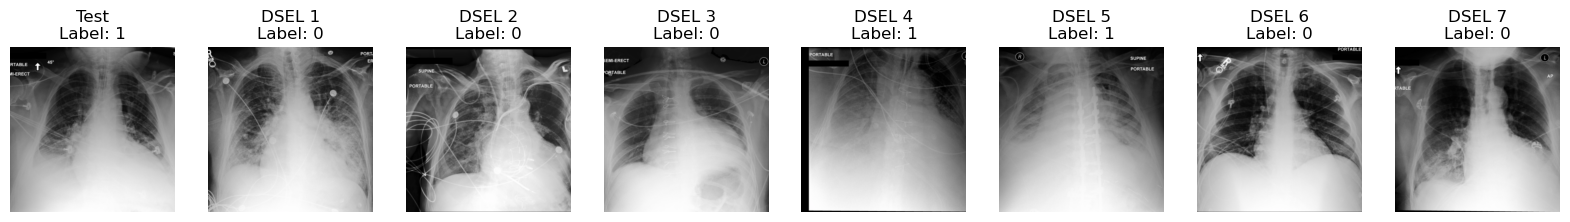

In [100]:
import matplotlib.pyplot as plt
import torch

# Function to unnormalize image if needed
def unnormalize_img(img_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(-1,1,1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(-1,1,1)
    img_tensor = img_tensor * std + mean
    img_tensor = img_tensor.clamp(0,1)
    return img_tensor

# Test sample
cxr_test_img = cxr_test[0].cpu()  # already a tensor
cxr_test_label = test_sample['label']

# DSEL images and labels
dsel_cxr_imgs = []
dsel_labels = []

for idx in topk_indices.cpu().numpy():
    # Convert memmap to tensor
    img_tensor = torch.tensor(val_dataset.cxr[idx]).float()
    dsel_cxr_imgs.append(img_tensor)
    dsel_labels.append(val_dataset.labels[idx])

# Plot
plt.figure(figsize=(20,4))
plt.subplot(1, topk+1, 1)
plt.imshow(unnormalize_img(cxr_test_img).permute(1,2,0))
plt.title(f"Test\nLabel: {cxr_test_label}")
plt.axis('off')

for i in range(topk):
    plt.subplot(1, topk+1, i+2)
    plt.imshow(unnormalize_img(dsel_cxr_imgs[i]).permute(1,2,0))
    plt.title(f"DSEL {i+1}\nLabel: {dsel_labels[i]}")
    plt.axis('off')

plt.show()


In [73]:
cxr_test_img

tensor([[[-2.0494, -2.0494, -2.0494,  ...,  0.3994,  0.4508,  0.4851],
         [-2.0494, -2.0494, -2.0494,  ...,  0.0398,  0.1426,  0.2624],
         [-2.0665, -2.0665, -2.0665,  ..., -1.1760, -1.0562, -0.9705],
         ...,
         [ 0.3652,  0.4166,  0.4166,  ...,  1.8037,  1.8208,  1.7865],
         [ 0.3994,  0.4337,  0.4337,  ...,  1.8208,  1.8037,  1.7865],
         [ 0.4337,  0.4337,  0.4508,  ...,  1.8379,  1.8037,  1.7865]],

        [[-1.9657, -1.9657, -1.9657,  ...,  0.5378,  0.5903,  0.6254],
         [-1.9657, -1.9657, -1.9657,  ...,  0.1702,  0.2752,  0.3978],
         [-1.9832, -1.9832, -1.9832,  ..., -1.0728, -0.9503, -0.8627],
         ...,
         [ 0.5028,  0.5553,  0.5553,  ...,  1.9734,  1.9909,  1.9559],
         [ 0.5378,  0.5728,  0.5728,  ...,  1.9909,  1.9734,  1.9559],
         [ 0.5728,  0.5728,  0.5903,  ...,  2.0084,  1.9734,  1.9559]],

        [[-1.7347, -1.7347, -1.7347,  ...,  0.7576,  0.8099,  0.8448],
         [-1.7347, -1.7347, -1.7347,  ...,  0